In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import callbacks

2025-03-07 16:47:33.826125: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 16:47:33.837975: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 16:47:33.928638: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-07 16:47:34.006614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741366054.087695   79018 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741366054.11

In [6]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


2025-03-07 16:47:39.623049: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669




2025-03-07 16:47:44.932369: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-07 16:47:45.065827: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


mask i,j :  tf.Tensor([0], shape=(1,), dtype=uint8)
mask i,j :  tf.Tensor([1], shape=(1,), dtype=uint8)


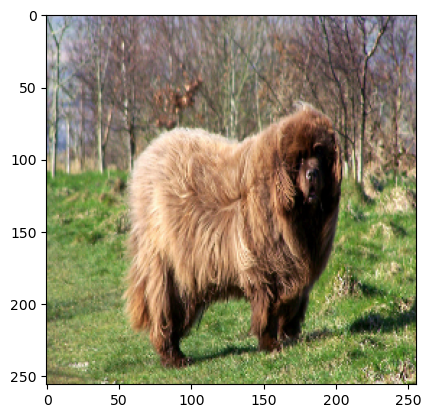

In [ ]:
from data_loading import OxfordPetDataset
from augmentation import batch
from models import clip_segmentation_model # 2_c exercise
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)
dataset.mask_prep()
dataset.heatmaps()

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(train.take(3)):  # Take three examples
    image_heatmap = example['image+heatmap']
    image = image_heatmap[:, :, :3]
    heatmap = np.expand_dims(image_heatmap[:, :, 3], axis=-1)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5)
    plt.title(f"Example {i+1}")
plt.show()
    


# for i, example in enumerate(train.take(2)):  # Take two examples
#     print(f"Example {i+1} - Image shape:", example['image'].shape)
#     image = example['image']
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, i+1)
#     plt.imshow(image)
#     label = example['label']
#     print(f"Example {i+1} - Label = ", label.numpy())
#     mask = example['segmentation_mask']  # This is the segmentation mask
#     plt.imshow(mask, cmap='gray', alpha=0.5)
#     print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
#     print("\n")
# plt.show()

In [4]:
def extract_image_mask(data):
    """Extract image and mask from dictionary"""
    return data['image'], data['segmentation_mask']

# Apply to all datasets
train = train.map(extract_image_mask)
val = val.map(extract_image_mask)
test = test.map(extract_image_mask)

BATCH_SIZE = 32

# Batch the data and use prefetching to optimize loading speed
# Apply augmentation dynamically during training. Augment argument instructions: 
# none = no augmentation, geometric = [geometric], color = [color], 
# color+geometric = [color, geometric], color+geometric+noise_filter = [color, geometric, noise_filter]
train_ds = batch(train, augment='color+geometric+noise_filter', batch_size=BATCH_SIZE)
val_ds = batch(val, augment='none', batch_size=BATCH_SIZE)
test_ds = batch(test, augment='none', batch_size=BATCH_SIZE)

In [5]:
# Initialize and compile model
from metrics import MeanIoUWrapper,dice_coefficient
from models import clip_segmentation_model
from tensorflow.keras.models import Model
import os

model = clip_segmentation_model(input_shape=reshape_size + (3,))
miou_metric = MeanIoUWrapper(num_classes=3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',miou_metric, dice_coefficient])
top_dir = "task_2c/baseline"
best_model_folder = os.path.join(top_dir, "Clip_model")
# Define callback to save the best model
checkpoint = ModelCheckpoint(
    best_model_folder,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

tf_model.h5:  36%|###6      | 220M/606M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[checkpoint,early_stopping]
)

Epoch 1/3
104/104 [==============================] - ETA: 0s - loss: 0.4458 - accuracy: 0.8169 - mean_iou: 0.5470 - dice_coefficient: 0.8171   
Epoch 1: val_loss improved from inf to 0.33330, saving model to task_2c/baseline\Clip_model


INFO:tensorflow:Assets written to: task_2c/baseline\Clip_model\assets


INFO:tensorflow:Assets written to: task_2c/baseline\Clip_model\assets


104/104 [==============================] - 91s 593ms/step - loss: 0.4458 - accuracy: 0.8169 - mean_iou: 0.5470 - dice_coefficient: 0.8171 - val_loss: 0.3333 - val_accuracy: 0.8574 - val_mean_iou: 0.5832 - val_dice_coefficient: 0.8562
Epoch 2/3
104/104 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.8606 - mean_iou: 0.6232 - dice_coefficient: 0.8607  
Epoch 2: val_loss improved from 0.33330 to 0.32184, saving model to task_2c/baseline\Clip_model


INFO:tensorflow:Assets written to: task_2c/baseline\Clip_model\assets


INFO:tensorflow:Assets written to: task_2c/baseline\Clip_model\assets


104/104 [==============================] - 54s 518ms/step - loss: 0.3301 - accuracy: 0.8606 - mean_iou: 0.6232 - dice_coefficient: 0.8607 - val_loss: 0.3218 - val_accuracy: 0.8634 - val_mean_iou: 0.6090 - val_dice_coefficient: 0.8625
Epoch 3/3
104/104 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8698 - mean_iou: 0.6455 - dice_coefficient: 0.8698 
Epoch 3: val_loss improved from 0.32184 to 0.29928, saving model to task_2c/baseline\Clip_model


INFO:tensorflow:Assets written to: task_2c/baseline\Clip_model\assets


INFO:tensorflow:Assets written to: task_2c/baseline\Clip_model\assets


104/104 [==============================] - 57s 554ms/step - loss: 0.3073 - accuracy: 0.8698 - mean_iou: 0.6455 - dice_coefficient: 0.8698 - val_loss: 0.2993 - val_accuracy: 0.8723 - val_mean_iou: 0.6412 - val_dice_coefficient: 0.8715


In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Define folder paths
top_dir = "task_2c/baseline"
best_model_folder = os.path.join(top_dir, "Clip_model")
results_folder = os.path.join(top_dir, "Clip_model_results")
os.makedirs(results_folder, exist_ok=True)

# Load the model without compiling to avoid custom object restoration issues.
best_model = tf.keras.models.load_model(best_model_folder, compile=False)

# Re-compile the model with the custom metrics.
best_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', MeanIoUWrapper(num_classes=3), dice_coefficient]
)

# Evaluate on validation set
val_metrics = best_model.evaluate(val_ds, return_dict=True)
val_loss = val_metrics['loss']
val_accuracy = val_metrics['accuracy']
val_iou = val_metrics['mean_iou']
val_dice = val_metrics['dice_coefficient']

# Evaluate on test set
test_metrics = best_model.evaluate(test_ds, return_dict=True)
print(test_metrics)
test_loss = test_metrics['loss']
test_accuracy = test_metrics['accuracy']
test_iou = test_metrics['mean_iou']
test_dice = test_metrics['dice_coefficient']


# Save test results in a separate CSV file
test_results = {
    "Loss": [test_loss],
    "Accuracy": [test_accuracy],
    "IoU": [test_iou],
    "Dice Coefficient": [test_dice]
}
test_results_df = pd.DataFrame(test_results)
test_csv_path = os.path.join(results_folder, "test_metrics.csv")
test_results_df.to_csv(test_csv_path, index=False)
print(f"Test metrics saved to {test_csv_path}")

# Plot training curves and save training history if available.
# 'history' is assumed to be a variable obtained from model.fit() during training.
if 'history' in globals():
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(results_folder, "loss_plot.png")
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved to {loss_plot_path}")

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    accuracy_plot_path = os.path.join(results_folder, "accuracy_plot.png")
    plt.savefig(accuracy_plot_path)
    plt.close()
    print(f"Accuracy plot saved to {accuracy_plot_path}")

    # Plot training and validation IoU
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mean_iou'], label='Training IoU')
    plt.plot(history.history['val_mean_iou'], label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    iou_plot_path = os.path.join(results_folder, "iou_plot.png")
    plt.savefig(iou_plot_path)
    plt.close()
    print(f"IoU plot saved to {iou_plot_path}")

    # Plot training and validation Dice Coefficient
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    dice_plot_path = os.path.join(results_folder, "dice_plot.png")
    plt.savefig(dice_plot_path)
    plt.close()
    print(f"Dice Coefficient plot saved to {dice_plot_path}")

    # Save the training history to a CSV file
    history_df = pd.DataFrame(history.history)
    history_csv_path = os.path.join(results_folder, "training_history.csv")
    history_df.to_csv(history_csv_path, index=False)
    print(f"Training history saved to {history_csv_path}")
else:
    print("Training history is not available as 'history' variable.")



115/115 [==============================] - 9s 80ms/step - loss: 0.3215 - accuracy: 0.8647 - mean_iou: 0.6367 - dice_coefficient: 0.8647
{'loss': 0.3214944005012512, 'accuracy': 0.8647025227546692, 'mean_iou': 0.6367175579071045, 'dice_coefficient': 0.864684522151947}
Test metrics saved to task_2c/baseline\Clip_model_results\test_metrics.csv
Loss plot saved to task_2c/baseline\Clip_model_results\loss_plot.png
Accuracy plot saved to task_2c/baseline\Clip_model_results\accuracy_plot.png
IoU plot saved to task_2c/baseline\Clip_model_results\iou_plot.png
Dice Coefficient plot saved to task_2c/baseline\Clip_model_results\dice_plot.png
Training history saved to task_2c/baseline\Clip_model_results\training_history.csv
